# Variational Autoencoder

## Setup

### Imports

In [39]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [40]:
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt

from autoencoders.variational_autoencoder import VariationalAutoencoder, Measure
from utils.stacked_mnist import StackedMNISTData, DataMode
from utils.verification_net import VerificationNet


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configuration

In [41]:
encoding_dim = 16
epochs = 50
batch_size = 256
force_relearn = False
mono_tolerance = 0.8
stacked_tolerance = 0.5
n_generated = 10000
prior_distribution = tfd.Independent(tfd.Normal(loc=tf.zeros(encoding_dim), scale=1), reinterpreted_batch_ndims=1)


## Mono MNIST

### Data

In [48]:
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE)
x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

(28, 28)


### Train

In [50]:
# Train autoencoder
autoencoder = VariationalAutoencoder(prior_distribution, encoding_dim, x_train.shape[1:3])
autoencoder.summary()
autoencoder.train(x_train, epochs=50, batch_size=batch_size, force_relearn=force_relearn)

Could not read weights for autoencoder from file. Must retrain...
Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_7 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 7, 7, 16)          6416      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 4, 4, 32)          12832     
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 2, 2, 32)          25632     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 1, 1, 64)          100416    
___________________________________________________________

In [6]:
# Train verification network
net = VerificationNet(force_learn=False)
net.train(generator=gen, epochs=epochs)

img, labels = gen.get_random_batch(training=True,  batch_size=25000)
cov = net.check_class_coverage(data=img, tolerance=.98)
pred, acc = net.check_predictability(data=img, correct_labels=labels)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

D:\Anaconda\envs\tf\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Coverage: 100.00%
Predictability: 98.33%
Accuracy: 98.10%


### Reconstruction

**Reconstruct images and display**

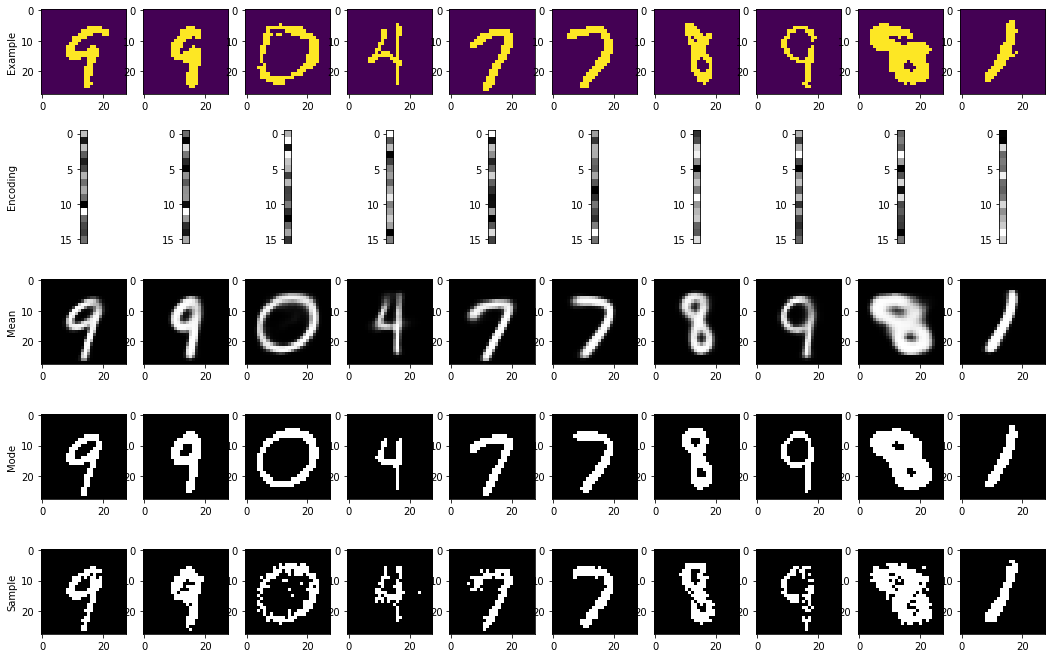

In [7]:
encoded = autoencoder.encode(x_test)

reconstructed_mean = autoencoder(x_test, output_measure=Measure.mean).numpy()
reconstructed_mode = autoencoder(x_test, output_measure=Measure.mode).numpy()
reconstructed_sample = autoencoder(x_test, output_measure=Measure.sample).numpy()

# Display some reconstructions
n_display = 10
idx = np.random.choice(x_test.shape[0], n_display, replace=False)
fig, ax = plt.subplots(5, n_display, figsize=(18, 12))
for i, n in enumerate(idx):
    ax[0][i].imshow(x_test[n], cmap='gray')
    ax[1][i].imshow(encoded[n], cmap='gray')
    ax[1][i].set_xticks([])
    ax[2][i].imshow(reconstructed_mean[n], cmap='gray')
    ax[3][i].imshow(reconstructed_mode[n], cmap='gray')
    ax[4][i].imshow(reconstructed_sample[n], cmap='gray')
ax[0][0].set_ylabel('Example')
ax[1][0].set_ylabel('Encoding')
ax[2][0].set_ylabel('Mean')
ax[3][0].set_ylabel('Mode')
ax[4][0].set_ylabel('Sample')
fig.align_ylabels()
plt.show()

**Assess reconstructions**

In [9]:
# Check coverage, predictability, and accuracy
print('---Mean---')
cov = net.check_class_coverage(data=reconstructed_mean, tolerance=.5)
pred, acc = net.check_predictability(data=reconstructed_mean, correct_labels=y_test, tolerance=.5)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

print('---Mode---')
cov = net.check_class_coverage(data=reconstructed_mode, tolerance=.5)
pred, acc = net.check_predictability(data=reconstructed_mode, correct_labels=y_test, tolerance=.5)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

print('---Sample---')
cov = net.check_class_coverage(data=reconstructed_sample, tolerance=.5)
pred, acc = net.check_predictability(data=reconstructed_sample, correct_labels=y_test, tolerance=.5)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

---Mean---
Coverage: 100.00%
Predictability: 89.64%
Accuracy: 70.14%
---Mode---
Coverage: 100.00%
Predictability: 99.60%
Accuracy: 94.69%
---Sample---
Coverage: 100.00%
Predictability: 97.99%
Accuracy: 92.78%


### Generation

**Generate images and display**

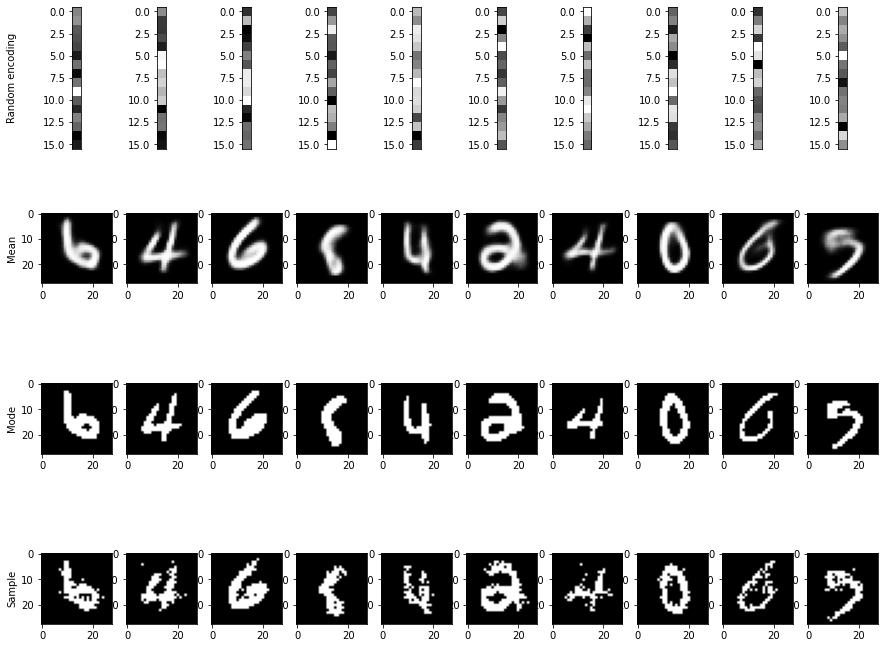

In [38]:
z = tf.reshape(prior_distribution.sample(10000), (10000, encoding_dim, 1))
generated_mean = autoencoder.decode(z, output_measure=Measure.mean).numpy()
generated_mode = autoencoder.decode(z, output_measure=Measure.mode).numpy()
generated_sample = autoencoder.decode(z, output_measure=Measure.sample).numpy()

# Display some generated images
n_display = 10
idx = np.random.choice(z.shape[0], n_display, replace=False)
fig, ax = plt.subplots(4, n_display, figsize=(15, 12))
for i, n in enumerate(idx):
    ax[0][i].imshow(z[n], cmap='gray')
    ax[0][i].set_xticks([])
    ax[1][i].imshow(generated_mean[n], cmap='gray')
    ax[2][i].imshow(generated_mode[n], cmap='gray')
    ax[3][i].imshow(generated_sample[n], cmap='gray')

ax[0][0].set_ylabel('Random encoding')
ax[1][0].set_ylabel('Mean')
ax[2][0].set_ylabel('Mode')
ax[3][0].set_ylabel('Sample')
fig.align_ylabels()
plt.show()

**Assess generation**

In [20]:
# Check coverage, predictability, and accuracy
print('---Mean---')
cov = net.check_class_coverage(data=generated_mean, tolerance=.8)
pred, _ = net.check_predictability(data=generated_mean, tolerance=.8)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

print('---Mode---')
cov = net.check_class_coverage(data=generated_mode, tolerance=.8)
pred, _ = net.check_predictability(data=generated_mode, tolerance=.8)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

print('---Sample---')
cov = net.check_class_coverage(data=generated_sample, tolerance=.8)
pred, _ = net.check_predictability(data=generated_sample, tolerance=.8)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

---Mean---
Coverage: 100.00%
Predictability: 62.47%
---Mode---
Coverage: 100.00%
Predictability: 89.27%
---Sample---
Coverage: 100.00%
Predictability: 75.53%


### Anomaly Detection

**Train new model**

In [ ]:
missing_gen = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING)

# Train autoencoder
x_train_missing, y_train_missing = missing_gen.get_full_data_set(training=True)

missing_autoencoder = VariationalAutoencoder(prior_distribution, encoding_dim, x_train_missing.shape[1:3], file_name="./models/variational_missing_autoencoder/autoencoder")
missing_autoencoder.summary()
missing_autoencoder.train(x_train_missing, epochs=epochs, batch_size=batch_size, force_relearn=force_relearn)


KeyboardInterrupt: 

In [ ]:
# Calculating reconstruction losses with test set with no missing digits
loss = missing_autoencoder.reconstruction_loss(x_test)

10000/10000 [==============================] - 57s 6ms/step - loss: 113.5184


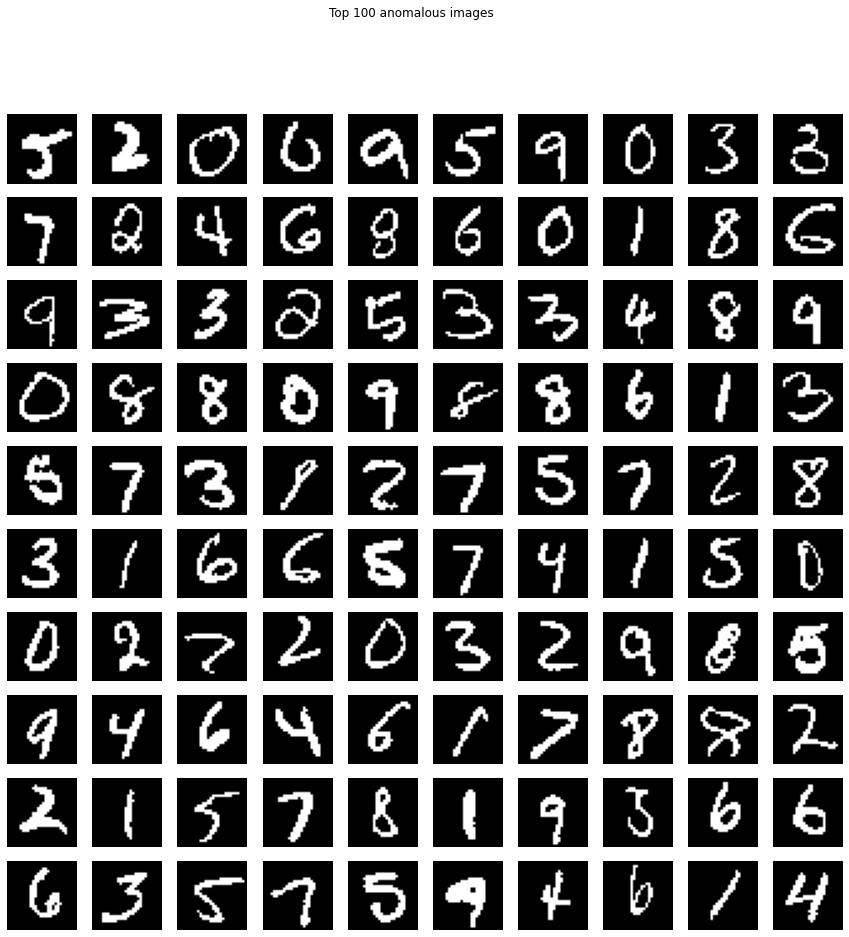

In [ ]:
# Display most anomolous images

grid_size = 10
# Get n largest loss indexes
idx = (-loss).argsort()[:grid_size**2]
fig, ax = plt.subplots(grid_size, grid_size, figsize=(15, 15))
for n in range(grid_size):
    for m in range(grid_size): 
        ax[n][m].imshow(x_test[idx[grid_size*n + m]], cmap='gray')
        ax[n][m].axis('off')
fig.suptitle(f'Top {grid_size**2} anomalous images')
plt.show()

## Color MNIST

### Data

In [21]:
color_gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE)
x_train_color, y_train_color = color_gen.get_full_data_set(training=True)
x_test_color, y_test_color = color_gen.get_full_data_set(training=False)

### Train

In [23]:
color_autoencoder = VariationalAutoencoder(prior_distribution=prior_distribution, encoding_dim=encoding_dim, x_train_missing.shape[1:3], file_name='./models/color_variational_autoencoder/autoencoder')
color_autoencoder.summary()
color_autoencoder.train(x_train_color, epochs=epochs, batch_size=batch_size, force_relearn=force_relearn)

Could not read weights for autoencoder from file. Must retrain...
Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 16)          6416      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 32)          12832     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 2, 2, 32)          25632     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 1, 64)          100416    
___________________________________________________________

True

### Reconstruction

**Reconstruct images and display**

In [26]:
encoded = color_autoencoder.encode(x_test_color)

reconstructed_mean = color_autoencoder(x_test_color, output_measure=Measure.mean).numpy()
reconstructed_mode = color_autoencoder(x_test_color, output_measure=Measure.mode).numpy()
reconstructed_sample = color_autoencoder(x_test_color, output_measure=Measure.sample).numpy()

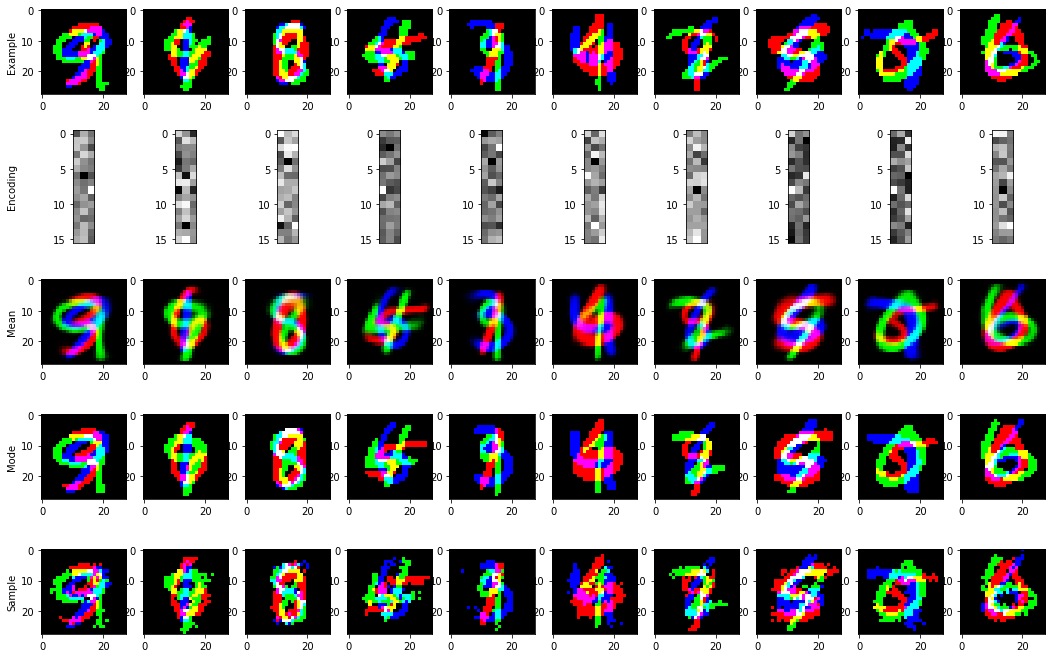

In [28]:
# Display some reconstructions
n_display = 10
idx = np.random.choice(x_test_color.shape[0], n_display, replace=False)
fig, ax = plt.subplots(5, n_display, figsize=(18, 12))
for i, n in enumerate(idx):
    ax[0][i].imshow(x_test_color[n] * 255)
    ax[1][i].imshow(encoded[n], cmap='gray')
    ax[1][i].set_xticks([])
    ax[2][i].imshow(reconstructed_mean[n])
    ax[3][i].imshow(reconstructed_mode[n])
    ax[4][i].imshow(reconstructed_sample[n])
ax[0][0].set_ylabel('Example')
ax[1][0].set_ylabel('Encoding')
ax[2][0].set_ylabel('Mean')
ax[3][0].set_ylabel('Mode')
ax[4][0].set_ylabel('Sample')
fig.align_ylabels()
plt.show()

**Assess reconstruction**

In [29]:
# Check coverage, predictability, and accuracy
print('---Mean---')
cov = net.check_class_coverage(data=reconstructed_mean, tolerance=.5)
pred, acc = net.check_predictability(data=reconstructed_mean, correct_labels=y_test_color, tolerance=.5)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

print('---Mode---')
cov = net.check_class_coverage(data=reconstructed_mode, tolerance=.5)
pred, acc = net.check_predictability(data=reconstructed_mode, correct_labels=y_test_color, tolerance=.5)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

print('---Sample---')
cov = net.check_class_coverage(data=reconstructed_sample, tolerance=.5)
pred, acc = net.check_predictability(data=reconstructed_sample, correct_labels=y_test_color, tolerance=.5)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

---Mean---
Coverage: 98.30%
Predictability: 78.34%
Accuracy: 54.69%
---Mode---
Coverage: 100.00%
Predictability: 98.74%
Accuracy: 86.29%
---Sample---
Coverage: 100.00%
Predictability: 95.02%
Accuracy: 81.75%


### Generation

**Generate images and display**

In [31]:
z = tf.reshape(prior_distribution.sample(30000), (10000, encoding_dim, 3))
generated_mean = autoencoder.decode(z, output_measure=Measure.mean).numpy()
generated_mode = autoencoder.decode(z, output_measure=Measure.mode).numpy()
generated_sample = autoencoder.decode(z, output_measure=Measure.sample).numpy()

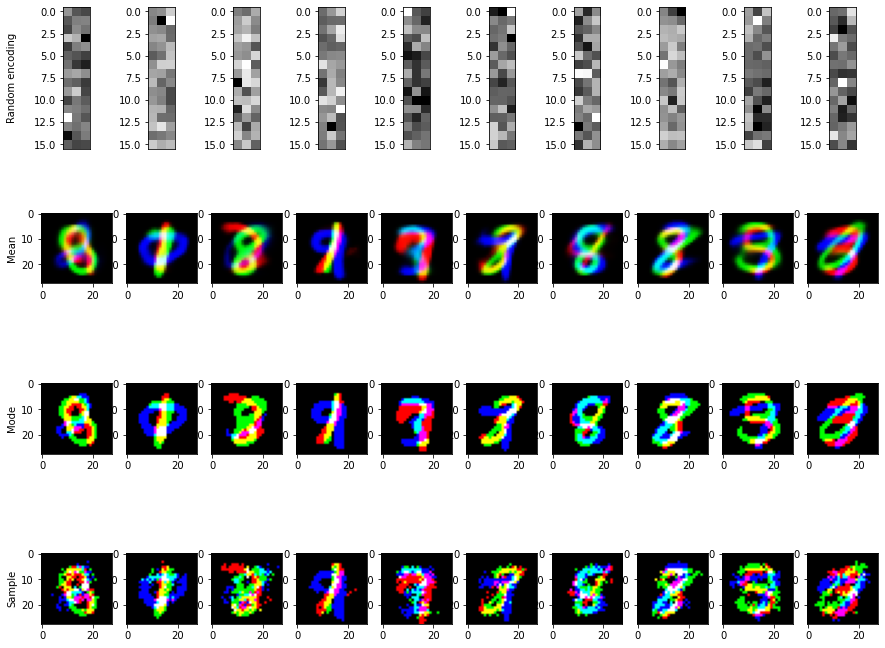

In [34]:
# Display some generated images
n_display = 10
idx = np.random.choice(z.shape[0], n_display, replace=False)
fig, ax = plt.subplots(4, n_display, figsize=(15, 12))
for i, n in enumerate(idx):
    ax[0][i].imshow(z[n], cmap='gray')
    ax[0][i].set_xticks([])
    ax[1][i].imshow(generated_mean[n])
    ax[2][i].imshow(generated_mode[n])
    ax[3][i].imshow(generated_sample[n])

ax[0][0].set_ylabel('Random encoding')
ax[1][0].set_ylabel('Mean')
ax[2][0].set_ylabel('Mode')
ax[3][0].set_ylabel('Sample')
fig.align_ylabels()
plt.show()

**Assess generation**

In [36]:
# Check coverage, predictability, and accuracy
print('---Mean---')
cov = net.check_class_coverage(data=generated_mean, tolerance=.5)
pred, _ = net.check_predictability(data=generated_mean, tolerance=.5)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

print('---Mode---')
cov = net.check_class_coverage(data=generated_mode, tolerance=.5)
pred, _ = net.check_predictability(data=generated_mode, tolerance=.5)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

print('---Sample---')
cov = net.check_class_coverage(data=generated_sample, tolerance=.5)
pred, _ = net.check_predictability(data=generated_sample, tolerance=.5)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

---Mean---
Coverage: 47.70%
Predictability: 49.63%
---Mode---
Coverage: 100.00%
Predictability: 89.75%
---Sample---
Coverage: 99.30%
Predictability: 67.87%
